# Black-Scholes Option Pricing: Theory, Simulation, and Market Comparison

#### Purpose of the notebook:

1. Implement analytical Black-Scholes-Merton pricing formulas
2. Develop Monte Carlo simulation methods
3. Compare theoretical prices with real market data
4. Analyze convergence and accuracy


## Introduction

The Black-Scholes-Merton model applies to European options on non dividend paying stocks. It can be extended to European options on stocks paying discrete dividends and to European options on other assets (such as stock indices, currencies, and futures). It does not apply to American options, which must be valued using the binomial tree methodology.

#### STOCK PRICE MOVEMENTS

The Black-Scholes-Merton model assumes that the return from a non-dividend paying stock over a short period of time is normally distributed. If $\mu$ is the mean return and $\sigma$ is the volatility, then the return in time $\Delta$t is assumed to be normal with mean
$\mu$$\Delta$t and standard deviation $\sigma$$\sqrt{\Delta t }$ .

When the return on a stock over a short period is normally distributed, the stock price at the end of a relatively long period has a lognormal distribution. This means the logarithm of the stock price (and not the stock price itself) is normally distributed.

#### THE PRICING FORMULAS

The Black-Scholes-Merton formulas for the price of a European call option (c) and a European put option (p) are:


\begin{equation*}
c = S_0 N \left(d1 \right) - K e^{-rT} N \left(d2 \right)
\end{equation*}


\begin{equation*}
p = K e^{-rT} N \left(-d2 \right) - S_0 N \left(-d1 \right) 
\end{equation*}

__Where:__

\begin{equation*}
d1 = \frac{ \ln{ \frac{S_0}{K} + \left(r + \frac{\sigma^2}{2} \right) T} }{\sigma \sqrt{T}}
\end{equation*}

and:

\begin{equation*}
d2 = \frac{ \ln{ \frac{S_0}{K} + \left(r - \frac{\sigma^2}{2} \right) T} }{\sigma \sqrt{T}} = d1 -  \sigma \sqrt{T}
\end{equation*}


and $N(d)$ is the cumulative normal distribution:
$$
N(d)= \frac{1}{\sqrt{2\pi}}\int_{-d}^{\infty} dx\; e^{-x^{2}/2}\,.
$$




__Where:__

\begin{alignat*}{1}
&c \quad & = \quad & \text{Call option price} \\
&S_0 \quad & = \quad & \text{Current stock (or other underlying) price} \\
&K \quad & = \quad & \text{Strike price} \\
&r \quad & = \quad & \text{Risk-free interest rate per year (continuously compounded) for a maturity of T} \\
&T \quad & = \quad & \text{time to maturity in years} \\
\end{alignat*}


#### ASSUMPTIONS OF THE BLACK–SCHOLES–MERTON (BSM)

Assumptions of the Black–Scholes–Merton (BSM) option pricing model

1. Market & trading assumptions
    - Frictionless markets: no transaction costs, taxes, or bid–ask spreads; trading can occur continuously.
    - Perfect liquidity & divisibility: you can buy/sell any quantity of the underlying (including fractional shares) without moving the price.
    - **No arbitrage**: markets do not allow riskless profit opportunities.
    - Continuous trading & continuous hedging: the option can be dynamically replicated by continuously adjusting a hedge (delta hedging).
2. Interest rates & financing
    - Constant risk-free rate: a known, constant risk-free interest rate applies over the option’s life.
    - **Borrowing/lending at the risk-free rate**: investors can both borrow and lend unlimited amounts at the same risk-free rate.
3. Underlying price dynamics
    - Geometric Brownian motion: the underlying **price follows a lognormal** diffusion process: **returns are normally distributed** (log-returns normal), price is always positive, continuous paths (no jumps).
    - Constant volatility: the volatility of the underlying return is constant over the option’s life.
4. Payout structure / instrument assumptions
    - **European-style exercise**: the option is exercised only at maturity (not early).
    - No dividends: the underlying pays no dividends or other cash flows during the option’s life
5. Information & timing
    - Parameters are known and stable: volatility and the risk-free rate are known (or treated as known) and do not change unexpectedly.
    - No default / counterparty risk (implicitly): the model ignores credit risk in the replication argument.




## 1. Import Required Libraries and Configuration

In [1]:
# Core numerical and data libraries
import numpy as np
import pandas as pd
from scipy.stats import norm
import math

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Market data
import yfinance as yf

# Utilities
from datetime import datetime, timedelta
from typing import Union, Tuple, Dict, List, Optional
import warnings
from functools import lru_cache

# Configuration
warnings.filterwarnings('ignore')

# Set consistent plotting style
sns.set_style('whitegrid')
plt.style.use('bmh')

# Set random seed for reproducibility
RANDOM_SEED = 3407
np.random.seed(RANDOM_SEED)

# Display settings
pd.set_option('display.precision', 6)
pd.set_option('display.max_columns', None)

print(f" Random seed set to: {RANDOM_SEED}")

 Random seed set to: 3407


## 2. Black-Scholes-Merton Analytical Pricing

### 2.1 Core Pricing Functions

In [2]:
def black_scholes_call(
    S: float,
    K: float,
    r: float,
    sigma: float,
    T: float,
    t: float = 0.0
) -> float:
    """
    Calculate European call option price using Black-Scholes formula.
    
    Parameters:
    -----------
    S : float
        Current stock price
    K : float
        Strike price
    r : float
        Risk-free interest rate (annualized)
    sigma : float
        Volatility (annualized)
    T : float
        Time to maturity (years)
    t : float, optional
        Current time (default: 0.0)
    
    Returns:
    --------
    float
        Call option price
    
    Raises:
    -------
    ValueError
        If input parameters are invalid
    
    Notes:
    ------
    Formula: C = S*N(d1) - K*exp(-r*τ)*N(d2)
    where τ = T - t (time to maturity)
    """
    # Input validation
    if S <= 0 or K <= 0:
        raise ValueError("Stock price and strike must be positive")
    if sigma <= 0:
        raise ValueError("Volatility must be positive")
    if T < t:
        raise ValueError("Maturity time must be >= current time")
    
    tau = T - t  # Time to maturity
    
    # Handle edge case: at or past maturity
    if tau < 1e-10:
        return max(S - K, 0.0)
    
    # Calculate d1 and d2
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    
    # Black-Scholes formula
    call_price = S * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)
    
    return call_price


def black_scholes_put(
    S: float,
    K: float,
    r: float,
    sigma: float,
    T: float,
    t: float = 0.0
) -> float:
    """
    Calculate European put option price using Black-Scholes formula.
    
    Returns:
    --------
    float
        Put option price
    
    Notes:
    ------
    Formula: P = K*exp(-r*τ)*N(-d2) - S*N(-d1)
    """
    # Input validation (same as call)
    if S <= 0 or K <= 0:
        raise ValueError("Stock price and strike must be positive")
    if sigma <= 0:
        raise ValueError("Volatility must be positive")
    if T < t:
        raise ValueError("Maturity time must be >= current time")
    
    tau = T - t
    
    # Handle edge case: at maturity
    if tau < 1e-10:
        return max(K - S, 0.0)
    
    # Calculate d1 and d2
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    
    # Black-Scholes put formula
    put_price = K * np.exp(-r * tau) * norm.cdf(-d2) - S * norm.cdf(-d1)
    
    return put_price


def black_scholes_prices(
    S: float,
    K: float,
    r: float,
    sigma: float,
    T: float,
    t: float = 0.0
) -> Tuple[float, float]:
    """
    Calculate both call and put option prices.
    
    Returns:
    --------
    tuple
        (call_price, put_price)
    """
    call_price = black_scholes_call(S, K, r, sigma, T, t)
    put_price = black_scholes_put(S, K, r, sigma, T, t)
    
    return call_price, put_price


def black_scholes_greeks(
    S: float,
    K: float,
    r: float,
    sigma: float,
    T: float,
    t: float = 0.0,
    option_type: str = 'call'
) -> Dict[str, float]:
    """
    Calculate option Greeks for European options.
    
    Parameters:
    -----------
    option_type : str
        'call' or 'put'
    
    Returns:
    --------
    dict
        Dictionary containing Delta, Gamma, Vega, Theta, and Rho
    
    Notes:
    ------
    - Delta: ∂V/∂S (rate of change with respect to underlying price)
    - Gamma: ∂²V/∂S² (rate of change of delta)
    - Vega: ∂V/∂σ (sensitivity to volatility)
    - Theta: ∂V/∂t (time decay)
    - Rho: ∂V/∂r (sensitivity to interest rate)
    """
    tau = T - t
    
    if tau < 1e-10:
        return {
            'Delta': 1.0 if S > K else 0.0,
            'Gamma': 0.0,
            'Vega': 0.0,
            'Theta': 0.0,
            'Rho': 0.0
        }
    
    # Calculate d1 and d2
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    
    # Common terms
    pdf_d1 = norm.pdf(d1)
    
    if option_type.lower() == 'call':
        delta = norm.cdf(d1)
        theta = (-S * pdf_d1 * sigma / (2 * np.sqrt(tau)) 
                 - r * K * np.exp(-r * tau) * norm.cdf(d2))
        rho = K * tau * np.exp(-r * tau) * norm.cdf(d2)
    else:  # put
        delta = -norm.cdf(-d1)
        theta = (-S * pdf_d1 * sigma / (2 * np.sqrt(tau)) 
                 + r * K * np.exp(-r * tau) * norm.cdf(-d2))
        rho = -K * tau * np.exp(-r * tau) * norm.cdf(-d2)
    
    # Greeks that are the same for call and put
    gamma = pdf_d1 / (S * sigma * np.sqrt(tau))
    vega = S * pdf_d1 * np.sqrt(tau)
    
    greeks = {
        'Delta': delta,
        'Gamma': gamma,
        'Vega': vega / 100,  # Per 1% change in volatility
        'Theta': theta / 365,  # Per day
        'Rho': rho / 100  # Per 1% change in interest rate
    }
    
    return greeks

### 2.2 Visualization: Option Prices vs Time

In [3]:
# Define standard parameters matching the problem statement
PARAMS = {
    'S': 214.0,       # Current stock price (USD)
    'K': 225.0,       # Strike price (USD)
    'r': 0.036,       # Risk-free rate (5% per annum)
    'sigma': 0.30,   # Volatility (30% per annum)
    'T': 1.5         # Time to maturity (18 months = 1.5 years)
}

print("="*60)
print("STANDARD PARAMETERS")
print("="*60)
for key, value in PARAMS.items():
    print(f"{key:8s} = {value}")
print("="*60)

STANDARD PARAMETERS
S        = 214.0
K        = 225.0
r        = 0.036
sigma    = 0.3
T        = 1.5


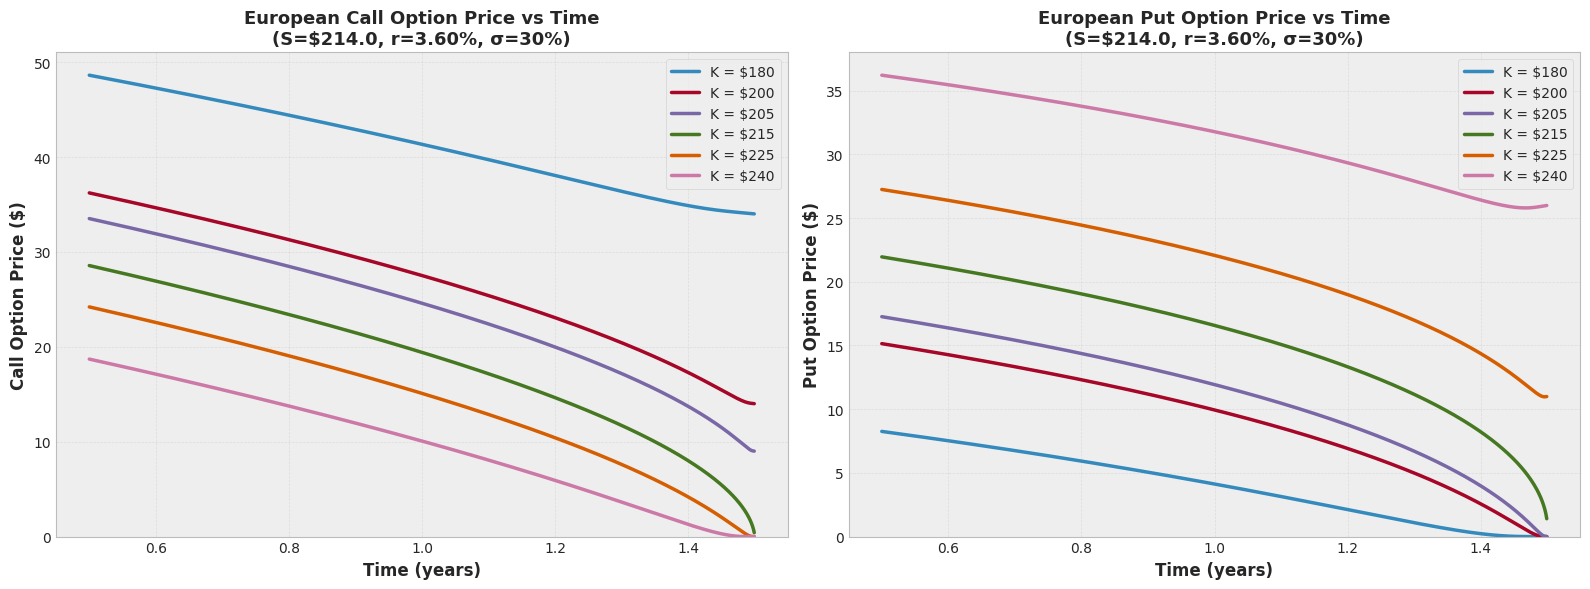

In [4]:
# Time array (from 6 months to near maturity)
t_array = np.linspace(0.5, 1.499, 1000)
strike_prices = [180, 200, 205, 215, 225, 240]

# Create plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot Call Options
for K in strike_prices:
    call_prices = [black_scholes_call(PARAMS['S'], K, PARAMS['r'], 
                                       PARAMS['sigma'], PARAMS['T'], t) 
                   for t in t_array]
    ax1.plot(t_array, call_prices, label=f'K = ${K}', linewidth=2.5)

ax1.set_xlabel('Time (years)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Call Option Price ($)', fontsize=12, fontweight='bold')
ax1.set_title(f'European Call Option Price vs Time\n(S=${PARAMS["S"]}, r={PARAMS["r"]*100:.2f}%, σ={PARAMS["sigma"]*100:.0f}%)', 
             fontsize=13, fontweight='bold')
ax1.legend(fontsize=10, loc='best')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(bottom=0)

# Plot Put Options
for K in strike_prices:
    put_prices = [black_scholes_put(PARAMS['S'], K, PARAMS['r'], 
                                     PARAMS['sigma'], PARAMS['T'], t) 
                   for t in t_array]
    ax2.plot(t_array, put_prices, label=f'K = ${K}', linewidth=2.5)

ax2.set_xlabel('Time (years)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Put Option Price ($)', fontsize=12, fontweight='bold')
ax2.set_title(f'European Put Option Price vs Time\n(S=${PARAMS["S"]}, r={PARAMS["r"]*100:.2f}%, σ={PARAMS["sigma"]*100:.0f}%)', 
             fontsize=13, fontweight='bold')
ax2.legend(fontsize=10, loc='best')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(bottom=0)

plt.tight_layout()
plt.show()


### 2.3 Payoff Diagrams at Maturity

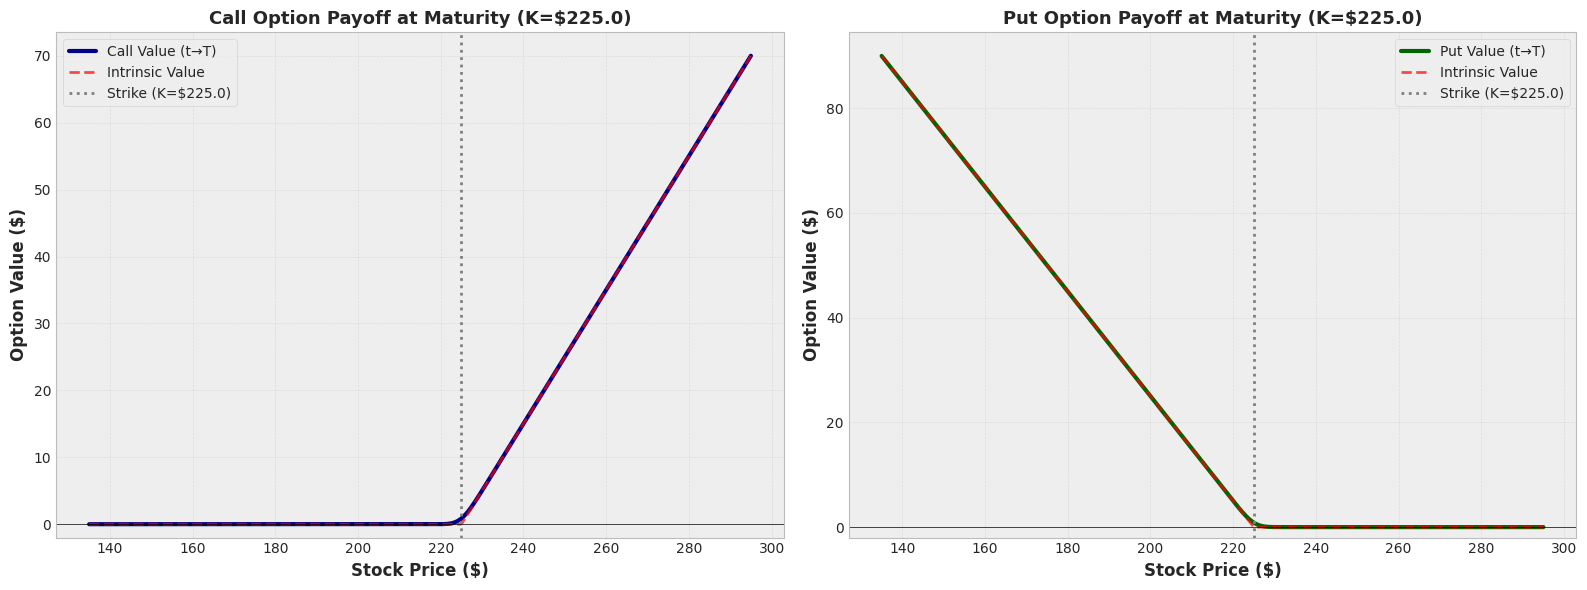

In [5]:
# Stock price range around strike
S_array = np.linspace(135, 295, 500)
K_ref = PARAMS['K']

# Calculate option values at maturity
call_at_maturity = np.array([black_scholes_call(s, K_ref, PARAMS['r'], 
                                                  PARAMS['sigma'], PARAMS['T'], 1.499) 
                             for s in S_array])
put_at_maturity = np.array([black_scholes_put(s, K_ref, PARAMS['r'], 
                                                PARAMS['sigma'], PARAMS['T'], 1.499) 
                            for s in S_array])

# Intrinsic values
call_intrinsic = np.maximum(S_array - K_ref, 0)
put_intrinsic = np.maximum(K_ref - S_array, 0)

# Create plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Call Option
ax1.plot(S_array, call_at_maturity, label='Call Value (t→T)', 
        linewidth=3, color='darkblue')
ax1.plot(S_array, call_intrinsic, '--', label='Intrinsic Value', 
        linewidth=2, color='red', alpha=0.7)
ax1.axvline(K_ref, color='gray', linestyle=':', linewidth=2, 
           label=f'Strike (K=${K_ref})')
ax1.axhline(0, color='black', linestyle='-', linewidth=0.5)

ax1.set_xlabel('Stock Price ($)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Option Value ($)', fontsize=12, fontweight='bold')
ax1.set_title(f'Call Option Payoff at Maturity (K=${K_ref})', 
             fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(bottom=-2)

# Put Option
ax2.plot(S_array, put_at_maturity, label='Put Value (t→T)', 
        linewidth=3, color='darkgreen')
ax2.plot(S_array, put_intrinsic, '--', label='Intrinsic Value', 
        linewidth=2, color='red', alpha=0.7)
ax2.axvline(K_ref, color='gray', linestyle=':', linewidth=2, 
           label=f'Strike (K=${K_ref})')
ax2.axhline(0, color='black', linestyle='-', linewidth=0.5)

ax2.set_xlabel('Stock Price ($)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Option Value ($)', fontsize=12, fontweight='bold')
ax2.set_title(f'Put Option Payoff at Maturity (K=${K_ref})', 
             fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_ylim(bottom=-2)

plt.tight_layout()
plt.show()


## 3. Monte Carlo Simulation Methods

### 3.1 Stock Price Path Simulation

In [6]:
def simulate_stock_paths(
    S0: float,
    r: float,
    sigma: float,
    T: float,
    n_steps: int,
    n_paths: int,
    random_seed: Optional[int] = None
) -> np.ndarray:
    """
    Simulate stock price paths using geometric Brownian motion.
    
    The stock price follows: dS = r*S*dt + σ*S*dW
    Discretized: S(t+dt) = S(t) * exp((r - σ²/2)*dt + σ*√dt*Z)
    
    Parameters:
    -----------
    S0 : float
        Initial stock price
    r : float
        Risk-free rate
    sigma : float
        Volatility
    T : float
        Time horizon (years)
    n_steps : int
        Number of time steps
    n_paths : int
        Number of simulation paths
    random_seed : int, optional
        Random seed for reproducibility
        
    Returns:
    --------
    np.ndarray
        Array of shape (n_steps+1, n_paths) containing simulated paths
    """
    if random_seed is not None:
        np.random.seed(random_seed)
    
    dt = T / n_steps
    
    # Pre-allocate array for efficiency
    S = np.zeros((n_steps + 1, n_paths))
    S[0, :] = S0
    
    # Generate all random numbers at once (vectorized)
    Z = np.random.standard_normal((n_steps, n_paths))
    
    # Simulate paths using vectorized operations
    drift = (r - 0.5 * sigma**2) * dt
    diffusion = sigma * np.sqrt(dt)
    
    for t in range(1, n_steps + 1):
        S[t, :] = S[t-1, :] * np.exp(drift + diffusion * Z[t-1, :])
    
    return S


def monte_carlo_option_price(
    S: float,
    K: float,
    r: float,
    sigma: float,
    T: float,
    t: float = 0.0,
    option_type: str = 'call',
    n_simulations: int = 100000,
    random_seed: Optional[int] = None
) -> Tuple[float, float, np.ndarray]:
    """
    Price European option using Monte Carlo simulation.
    
    Parameters:
    -----------
    option_type : str
        'call' or 'put'
    n_simulations : int
        Number of Monte Carlo simulations
    random_seed : int, optional
        Random seed for reproducibility
        
    Returns:
    --------
    tuple
        (option_price, standard_error, payoffs_array)
    """
    if random_seed is not None:
        np.random.seed(random_seed)
    
    tau = T - t
    
    if tau < 1e-10:
        if option_type.lower() == 'call':
            return max(S - K, 0), 0.0, np.array([max(S - K, 0)])
        else:
            return max(K - S, 0), 0.0, np.array([max(K - S, 0)])
    
    # Generate random standard normal variables
    Z = np.random.standard_normal(n_simulations)
    
    # Simulate terminal stock prices
    ST = S * np.exp((r - 0.5 * sigma**2) * tau + sigma * np.sqrt(tau) * Z)
    
    # Calculate payoffs
    if option_type.lower() == 'call':
        payoffs = np.maximum(ST - K, 0)
    else:  # put
        payoffs = np.maximum(K - ST, 0)
    
    # Discount back to present value
    discount_factor = np.exp(-r * tau)
    option_price = discount_factor * np.mean(payoffs)
    
    # Calculate standard error
    standard_error = discount_factor * np.std(payoffs, ddof=1) / np.sqrt(n_simulations)
    
    return option_price, standard_error, payoffs

### 3.2 Visualize Simulated Paths

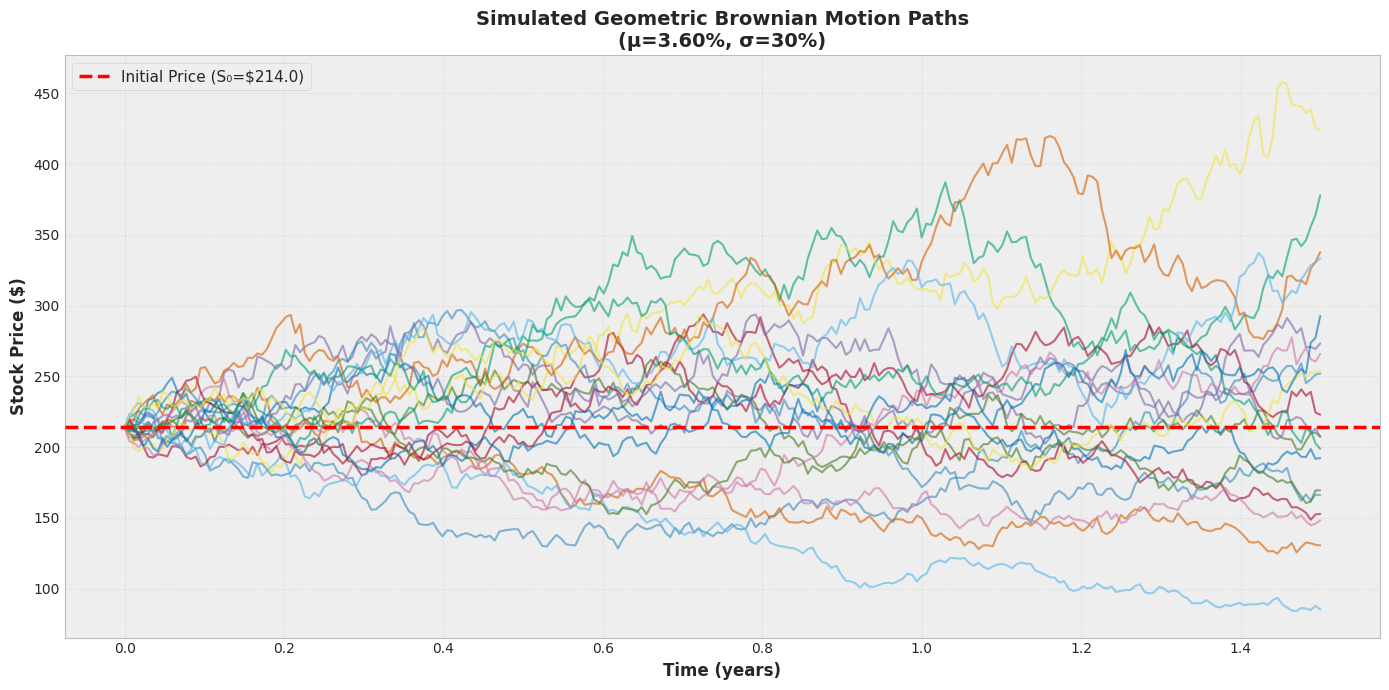

In [7]:
# Simulate sample paths
n_paths_display = 20
S_paths = simulate_stock_paths(
    S0=PARAMS['S'],
    r=PARAMS['r'],
    sigma=PARAMS['sigma'],
    T=PARAMS['T'],
    n_steps=252,  # Daily steps
    n_paths=n_paths_display,
    random_seed=RANDOM_SEED
)

# Plot
fig, ax = plt.subplots(figsize=(14, 7))
time_grid = np.linspace(0, PARAMS['T'], S_paths.shape[0])

for i in range(n_paths_display):
    ax.plot(time_grid, S_paths[:, i], alpha=0.6, linewidth=1.5)

ax.axhline(PARAMS['S'], color='red', linestyle='--', linewidth=2.5, 
           label=f'Initial Price (S₀=${PARAMS["S"]})', zorder=10)
ax.set_xlabel('Time (years)', fontsize=12, fontweight='bold')
ax.set_ylabel('Stock Price ($)', fontsize=12, fontweight='bold')
ax.set_title(f'Simulated Geometric Brownian Motion Paths\n(μ={PARAMS["r"]*100:.2f}%, σ={PARAMS["sigma"]*100:.0f}%)', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 3.3 Distribution of Terminal Stock Prices

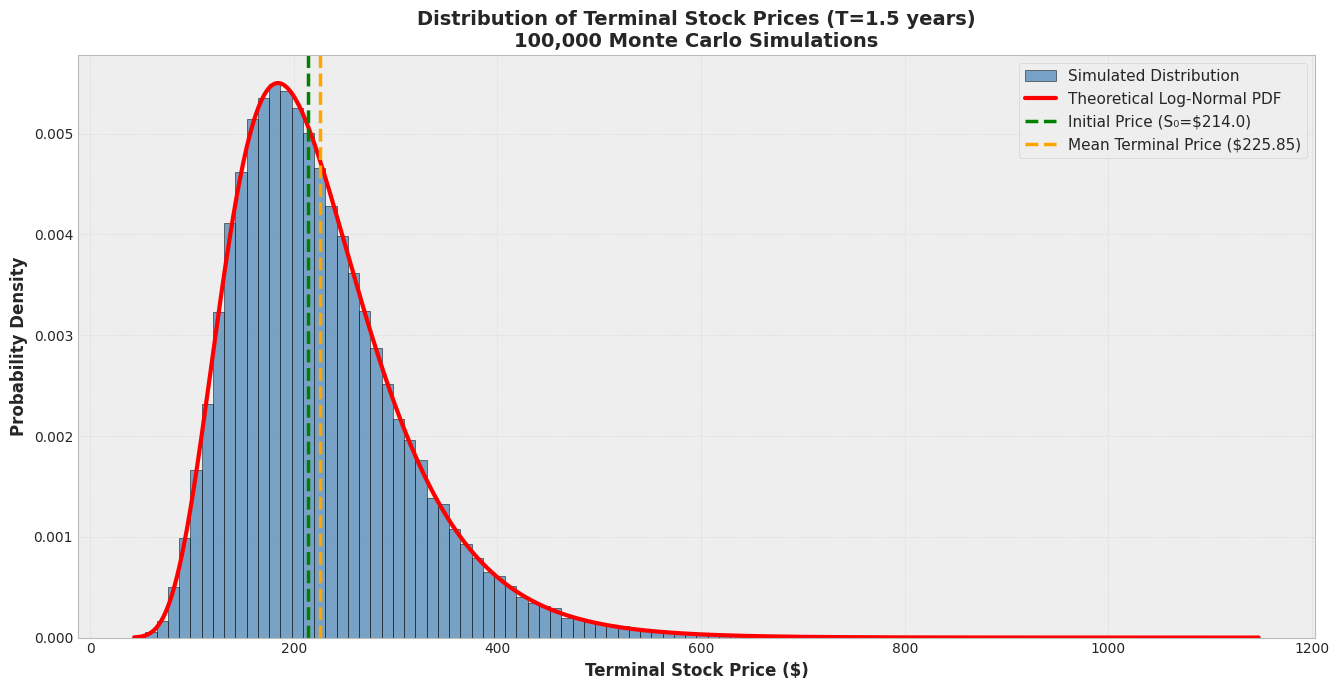

 Terminal price statistics:
  Mean: $225.85
  Std:  $86.27
  Min:  $43.16
  Max:  $1147.63


In [8]:
# Simulate large number of paths
S_paths_large = simulate_stock_paths(
    S0=PARAMS['S'],
    r=PARAMS['r'],
    sigma=PARAMS['sigma'],
    T=PARAMS['T'],
    n_steps=100,
    n_paths=100000,
    random_seed=RANDOM_SEED
)

# Extract terminal prices
ST_simulated = S_paths_large[-1, :]

# Calculate theoretical log-normal parameters
mu_ln = np.log(PARAMS['S']) + (PARAMS['r'] - 0.5 * PARAMS['sigma']**2) * PARAMS['T']
sigma_ln = PARAMS['sigma'] * np.sqrt(PARAMS['T'])

# Theoretical distribution
ST_theoretical = np.linspace(ST_simulated.min(), ST_simulated.max(), 1000)
pdf_theoretical = (1 / (ST_theoretical * sigma_ln * np.sqrt(2 * np.pi))) * \
                  np.exp(-((np.log(ST_theoretical) - mu_ln)**2) / (2 * sigma_ln**2))

# Plot
fig, ax = plt.subplots(figsize=(13.5, 7))

ax.hist(ST_simulated, bins=100, density=True, alpha=0.7, 
        color='steelblue', edgecolor='black', label='Simulated Distribution')
ax.plot(ST_theoretical, pdf_theoretical, 'r-', linewidth=3, 
        label='Theoretical Log-Normal PDF')
ax.axvline(PARAMS['S'], color='green', linestyle='--', linewidth=2.5, 
           label=f'Initial Price (S₀=${PARAMS["S"]})')
ax.axvline(np.mean(ST_simulated), color='orange', linestyle='--', linewidth=2.5, 
           label=f'Mean Terminal Price (${np.mean(ST_simulated):.2f})')

ax.set_xlabel('Terminal Stock Price ($)', fontsize=12, fontweight='bold')
ax.set_ylabel('Probability Density', fontsize=12, fontweight='bold')
ax.set_title(f'Distribution of Terminal Stock Prices (T={PARAMS["T"]} years)\n100,000 Monte Carlo Simulations', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f" Terminal price statistics:")
print(f"  Mean: ${np.mean(ST_simulated):.2f}")
print(f"  Std:  ${np.std(ST_simulated):.2f}")
print(f"  Min:  ${np.min(ST_simulated):.2f}")
print(f"  Max:  ${np.max(ST_simulated):.2f}")

## 4. Comparison: Monte Carlo vs Analytical Solution

### 4.1 Point Estimates

In [9]:
# Test cases
test_cases = [
    {'K': 205, 't': 1.4, 'desc': 'Near Maturity, ITM'},
    {'K': 214, 't': 1.0, 'desc': 'Mid-Term, ATM'},
    {'K': 225, 't': 0.5, 'desc': 'Early, OTM'},
]

print("\n" + "="*80)
print("COMPARISON: MONTE CARLO vs ANALYTICAL BLACK-SCHOLES")
print("="*80)

for i, case in enumerate(test_cases, 1):
    K = case['K']
    t = case['t']
    
    # Monte Carlo
    mc_call, mc_se_call, _ = monte_carlo_option_price(
        PARAMS['S'], K, PARAMS['r'], PARAMS['sigma'], PARAMS['T'], t,
        option_type='call', n_simulations=100000, random_seed=RANDOM_SEED
    )
    
    # Analytical
    bs_call = black_scholes_call(PARAMS['S'], K, PARAMS['r'], 
                                  PARAMS['sigma'], PARAMS['T'], t)
    
    print(f"\nTest Case {i}: {case['desc']}")
    print(f"  Strike (K):           ${K}")
    print(f"  Time (t):             {t:.3f} years")
    print(f"  Time to Maturity:     {PARAMS['T'] - t:.3f} years")
    print(f"  {'─'*70}")
    print(f"  Monte Carlo Price:    ${mc_call:.6f} ± ${mc_se_call:.6f}")
    print(f"  Analytical Price:     ${bs_call:.6f}")
    print(f"  Absolute Error:       ${abs(mc_call - bs_call):.6f}")
    print(f"  Relative Error:       {100 * abs(mc_call - bs_call) / bs_call:.4f}%")

print("="*80)


COMPARISON: MONTE CARLO vs ANALYTICAL BLACK-SCHOLES

Test Case 1: Near Maturity, ITM
  Strike (K):           $205
  Time (t):             1.400 years
  Time to Maturity:     0.100 years
  ──────────────────────────────────────────────────────────────────────
  Monte Carlo Price:    $13.757536 ± $0.049586
  Analytical Price:     $13.713911
  Absolute Error:       $0.043625
  Relative Error:       0.3181%

Test Case 2: Mid-Term, ATM
  Strike (K):           $214
  Time (t):             1.000 years
  Time to Maturity:     0.500 years
  ──────────────────────────────────────────────────────────────────────
  Monte Carlo Price:    $19.975923 ± $0.099696
  Analytical Price:     $19.888335
  Absolute Error:       $0.087588
  Relative Error:       0.4404%

Test Case 3: Early, OTM
  Strike (K):           $225
  Time (t):             0.500 years
  Time to Maturity:     1.000 years
  ──────────────────────────────────────────────────────────────────────
  Monte Carlo Price:    $24.327126 ± $0.140

### 4.2 Convergence Analysis

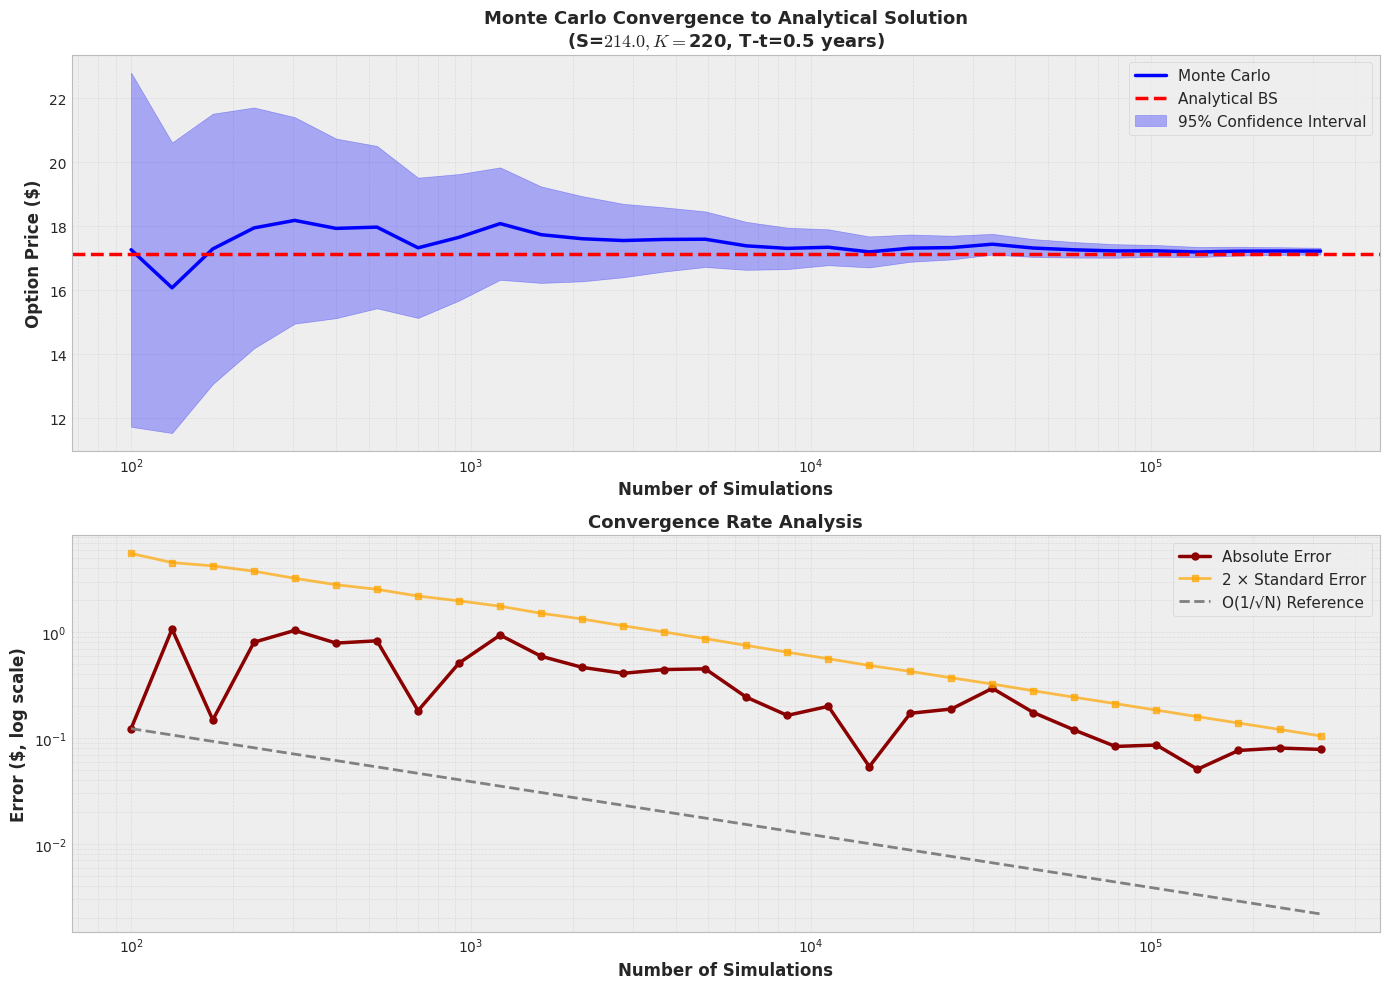

 Convergence analysis complete
  Final error with 316,227 simulations: $0.078219
  Relative error: 0.4562%


In [10]:
# Convergence study parameters
K_test = 220
t_test = 1.0

# Analytical benchmark
bs_benchmark = black_scholes_call(PARAMS['S'], K_test, PARAMS['r'], 
                                   PARAMS['sigma'], PARAMS['T'], t_test)

# Simulation sizes
n_simulations_range = np.logspace(2, 5.5, 30, dtype=int)  # 100 to ~300,000

mc_prices = []
mc_errors = []

for n_sims in n_simulations_range:
    price, se, _ = monte_carlo_option_price(
        PARAMS['S'], K_test, PARAMS['r'], PARAMS['sigma'], PARAMS['T'], t_test,
        option_type='call', n_simulations=int(n_sims), random_seed=RANDOM_SEED
    )
    mc_prices.append(price)
    mc_errors.append(se)

mc_prices = np.array(mc_prices)
mc_errors = np.array(mc_errors)
absolute_errors = np.abs(mc_prices - bs_benchmark)

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Price convergence
ax1.plot(n_simulations_range, mc_prices, linewidth=2.5, label='Monte Carlo', color='blue')
ax1.axhline(bs_benchmark, color='red', linestyle='--', linewidth=2.5, label='Analytical BS')
ax1.fill_between(n_simulations_range, mc_prices - 2*mc_errors, 
                  mc_prices + 2*mc_errors, alpha=0.3, color='blue', 
                  label='95% Confidence Interval')
ax1.set_xscale('log')
ax1.set_xlabel('Number of Simulations', fontsize=12, fontweight='bold')
ax1.set_ylabel('Option Price ($)', fontsize=12, fontweight='bold')
ax1.set_title(f'Monte Carlo Convergence to Analytical Solution\n(S=${PARAMS["S"]}, K=${K_test}, T-t={PARAMS["T"]-t_test:.1f} years)', 
              fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, which='both')

# Error convergence (log-log plot)
ax2.loglog(n_simulations_range, absolute_errors, 'o-', linewidth=2.5, 
           markersize=5, color='darkred', label='Absolute Error')
ax2.loglog(n_simulations_range, 2 * mc_errors, 's-', linewidth=2, 
           markersize=4, color='orange', alpha=0.7, label='2 × Standard Error')

# Reference line: O(1/√N)
reference_line = absolute_errors[0] * np.sqrt(n_simulations_range[0] / n_simulations_range)
ax2.loglog(n_simulations_range, reference_line, '--', linewidth=2, 
           color='gray', label='O(1/√N) Reference')

ax2.set_xlabel('Number of Simulations', fontsize=12, fontweight='bold')
ax2.set_ylabel('Error ($, log scale)', fontsize=12, fontweight='bold')
ax2.set_title('Convergence Rate Analysis', fontsize=13, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print(f" Convergence analysis complete")
print(f"  Final error with {n_simulations_range[-1]:,} simulations: ${absolute_errors[-1]:.6f}")
print(f"  Relative error: {100 * absolute_errors[-1] / bs_benchmark:.4f}%")

## 5. Real Market Data Analysis

### 5.1 Data Fetching Functions

In [11]:
@lru_cache(maxsize=32)
def fetch_ticker_data(symbol: str) -> yf.Ticker:
    """
    Fetch ticker data with caching.
    
    Parameters:
    -----------
    symbol : str
        Stock ticker symbol
        
    Returns:
    --------
    yf.Ticker
        Yahoo Finance ticker object
    """
    try:
        ticker = yf.Ticker(symbol)
        # Test if ticker is valid
        _ = ticker.history(period='1d')
        return ticker
    except Exception as e:
        raise ValueError(f"Failed to fetch data for {symbol}: {str(e)}")


def get_current_price(ticker: yf.Ticker) -> float:
    """
    Get current stock price.
    
    Returns:
    --------
    float
        Current closing price
    """
    try:
        hist = ticker.history(period='5d')
        if hist.empty:
            raise ValueError("No price data available")
        return hist['Close'].iloc[-1]
    except Exception as e:
        raise ValueError(f"Failed to get current price: {str(e)}")


def calculate_time_to_maturity(expiration_date_str: str) -> float:
    """
    Calculate time to maturity in years.
    
    Parameters:
    -----------
    expiration_date_str : str
        Expiration date in 'YYYY-MM-DD' format
        
    Returns:
    --------
    float
        Time to maturity in years
    """
    expiration_date = datetime.strptime(expiration_date_str, "%Y-%m-%d")
    today = datetime.now()
    days_to_maturity = (expiration_date - today).days
    
    if days_to_maturity < 0:
        return 0.0
    
    return days_to_maturity / 365.0


def get_risk_free_rate(days_to_maturity: int) -> float:
    """
    Get risk-free rate based on time to maturity.
    
    Uses yield curve data (as of December 20, 2025). https://www.investing.com/rates-bonds/usa-government-bonds
    
    Parameters:
    -----------
    days_to_maturity : int
        Number of days to option maturity
        
    Returns:
    --------
    float
        Risk-free rate (annualized)
    """
    # Yield curve (days: rate)
    yield_curve = {
        30: 3.620,      # U.S. 1M
        60: 3.645,      # U.S. 2M
        90: 3.612,      # U.S. 3M
        120: 3.634,     # U.S. 4M
        180: 3.606,     # U.S. 6M
        365: 3.514,     # U.S. 1Y
        730: 3.485,     # U.S. 2Y
        1095: 3.529,    # U.S. 3Y
        1825: 3.695,    # U.S. 5Y
        2555: 3.907,    # U.S. 7Y
        3650: 4.151,    # U.S. 10Y
        7300: 4.785,    # U.S. 20Y
        10950: 4.828,   # U.S. 30Y
    }
    
    # Find appropriate rate
    sorted_maturities = sorted(yield_curve.keys())
    
    if days_to_maturity <= 0:
        return yield_curve[30] / 100  # Use 1-month rate as default
    elif days_to_maturity >= sorted_maturities[-1]:
        return yield_curve[sorted_maturities[-1]] / 100
    else:
        # Find the next higher maturity
        for maturity in sorted_maturities:
            if days_to_maturity <= maturity:
                return yield_curve[maturity] / 100
    
    return yield_curve[365] / 100  # Default to 1-year rate

### 5.2 Fetch and Analyze Market Data

In [12]:
# Fetch data for Boeing (BA)
TICKER_SYMBOL = 'BA'

try:
    print(f"Fetching data for {TICKER_SYMBOL}...")
    ticker = fetch_ticker_data(TICKER_SYMBOL)
    
    # Get current price
    current_price = get_current_price(ticker)
    print(f" Current price: ${current_price:.2f}")
    
    # Get option expirations
    expirations = ticker.options
    if not expirations:
        print("No options available for this ticker")
        expirations = []
    else:
        print(f" Available expirations: {len(expirations)}")
        print(f"  First: {expirations[0]}")
        print(f"  Last:  {expirations[-1]}")
    
    # Get company info
    try:
        company_name = ticker.info.get('shortName', TICKER_SYMBOL)
    except Exception as e:
        print(f"Warning: Could not fetch company info: {e}")
        company_name = TICKER_SYMBOL
    
    print(f" Company: {company_name}")
    
except Exception as e:
    print(f" Error: {str(e)}")
    print("Using synthetic data for demonstration...")
    current_price = PARAMS['S']
    expirations = ['2026-01-16', '2026-02-20']  # Synthetic expirations
    company_name = "Synthetic Data"

Fetching data for BA...
 Current price: $214.08
 Available expirations: 18
  First: 2025-12-26
  Last:  2028-01-21
 Company: Boeing Company (The)


In [13]:
# Analyze options for first two expirations
n_expirations_to_analyze = min(2, len(expirations))

option_data = {}

for i in range(n_expirations_to_analyze):
    exp_date = expirations[i]
    
    try:
        # Fetch option chain
        opt_chain = ticker.option_chain(exp_date)
        calls = opt_chain.calls
        
        # Calculate parameters
        tau = calculate_time_to_maturity(exp_date)
        days_to_mat = int(tau * 365)
        rf_rate = get_risk_free_rate(days_to_mat)
        
        # Extract relevant data
        strikes = calls['strike'].values
        market_prices = calls['lastPrice'].values
        implied_vols = calls['impliedVolatility'].values
        
        # Calculate Black-Scholes prices
        bs_prices = np.array([
            black_scholes_call(current_price, K, rf_rate, sigma, tau, 0)
            for K, sigma in zip(strikes, implied_vols)
        ])
        
        option_data[exp_date] = {
            'strikes': strikes,
            'market_prices': market_prices,
            'bs_prices': bs_prices,
            'implied_vols': implied_vols,
            'time_to_maturity': tau,
            'risk_free_rate': rf_rate
        }
        
        print(f"\n Processed expiration {exp_date}:")
        print(f"  Time to maturity: {tau:.4f} years ({days_to_mat} days)")
        print(f"  Risk-free rate:   {rf_rate*100:.3f}%")
        print(f"  Number of strikes: {len(strikes)}")
        
    except Exception as e:
        print(f" Error processing {exp_date}: {str(e)}")


 Processed expiration 2025-12-26:
  Time to maturity: 0.0137 years (5 days)
  Risk-free rate:   3.620%
  Number of strikes: 33

 Processed expiration 2026-01-02:
  Time to maturity: 0.0329 years (11 days)
  Risk-free rate:   3.620%
  Number of strikes: 31


### 5.3 Visualize Market vs Model Prices

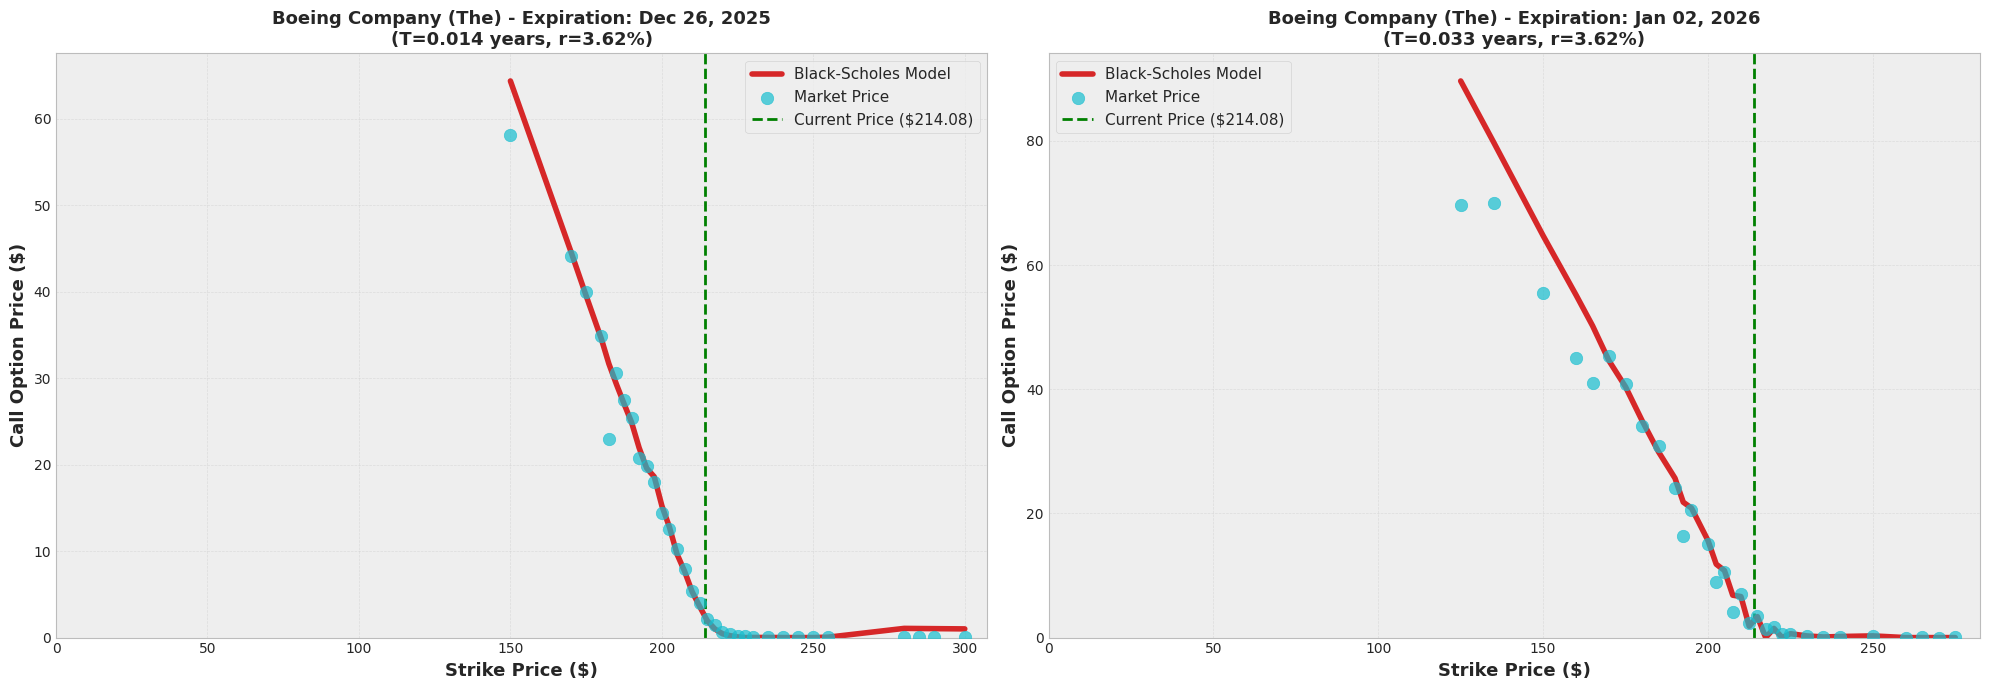


 Market comparison plots generated

Note: Differences between Black-Scholes and market prices may be due to:
  • Liquidity constraints (especially for deep OTM/ITM options)
  • Bid-ask spreads
  • Market microstructure effects
  • Stale prices (last traded price may not reflect current value)
  • Violations of Black-Scholes assumptions (e.g., volatility smile)


In [14]:
if option_data:
    n_plots = len(option_data)
    fig, axes = plt.subplots(1, n_plots, figsize=(10*n_plots, 7))
    
    if n_plots == 1:
        axes = [axes]
    
    for ax, (exp_date, data) in zip(axes, option_data.items()):
        # Plot
        ax.plot(data['strikes'], data['bs_prices'], 
                color='tab:red', linewidth=4, label='Black-Scholes Model', zorder=2)
        ax.scatter(data['strikes'], data['market_prices'], 
                   color='tab:cyan', s=80, alpha=0.7, label='Market Price', zorder=3)
        ax.axvline(current_price, color='green', linestyle='--', 
                   linewidth=2, label=f'Current Price (${current_price:.2f})', zorder=1)
        
        # Formatting
        ax.set_xlabel("Strike Price ($)", fontsize=13, fontweight='bold')
        ax.set_ylabel("Call Option Price ($)", fontsize=13, fontweight='bold')
        ax.set_title(f"{company_name} - Expiration: {datetime.strptime(exp_date, '%Y-%m-%d').strftime('%b %d, %Y')}\n"
                     f"(T={data['time_to_maturity']:.3f} years, r={data['risk_free_rate']*100:.2f}%)",
                     fontsize=13, fontweight='bold')
        ax.legend(fontsize=11, loc='best')
        ax.grid(True, alpha=0.3)
        ax.set_xlim(left=0)
        ax.set_ylim(bottom=0)
    
    plt.tight_layout()
    plt.show()
    
    print("\n Market comparison plots generated")
    print("\nNote: Differences between Black-Scholes and market prices may be due to:")
    print("  • Liquidity constraints (especially for deep OTM/ITM options)")
    print("  • Bid-ask spreads")
    print("  • Market microstructure effects")
    print("  • Stale prices (last traded price may not reflect current value)")
    print("  • Violations of Black-Scholes assumptions (e.g., volatility smile)")
else:
    print("No option data available for visualization")

## 6. Comprehensive Performance Summary

In [15]:
# Create comprehensive comparison table
comparison_data = []

strike_test_values = [205, 215, 235]
time_test_values = [0.5, 1.0, 1.4]

print("\nGenerating comprehensive comparison table...")

for K in strike_test_values:
    for t in time_test_values:
        # Analytical
        bs_call = black_scholes_call(PARAMS['S'], K, PARAMS['r'], 
                                      PARAMS['sigma'], PARAMS['T'], t)
        bs_put = black_scholes_put(PARAMS['S'], K, PARAMS['r'], 
                                     PARAMS['sigma'], PARAMS['T'], t)
        
        # Monte Carlo
        mc_call, mc_se_call, _ = monte_carlo_option_price(
            PARAMS['S'], K, PARAMS['r'], PARAMS['sigma'], PARAMS['T'], t,
            option_type='call', n_simulations=100000, random_seed=RANDOM_SEED
        )
        
        mc_put, mc_se_put, _ = monte_carlo_option_price(
            PARAMS['S'], K, PARAMS['r'], PARAMS['sigma'], PARAMS['T'], t,
            option_type='put', n_simulations=100000, random_seed=RANDOM_SEED
        )
        
        # Calculate errors
        call_abs_error = abs(mc_call - bs_call)
        call_rel_error = 100 * call_abs_error / bs_call if bs_call > 0 else 0
        
        put_abs_error = abs(mc_put - bs_put)
        put_rel_error = 100 * put_abs_error / bs_put if bs_put > 0 else 0
        
        comparison_data.append({
            'Strike (K)': K,
            'Time (t)': t,
            'τ (T-t)': PARAMS['T'] - t,
            'BS Call': bs_call,
            'MC Call': mc_call,
            'Call Error (%)': call_rel_error,
            'BS Put': bs_put,
            'MC Put': mc_put,
            'Put Error (%)': put_rel_error
        })

df_comparison = pd.DataFrame(comparison_data)

print("\n" + "="*100)
print(f"COMPREHENSIVE COMPARISON: {company_name.upper()}")
print(f"Parameters: S=${PARAMS['S']}, r={PARAMS['r']*100:.2f}%, σ={PARAMS['sigma']*100:.0f}%, T={PARAMS['T']} years")
print("="*100)
print(df_comparison.to_string(index=False, float_format=lambda x: f'{x:.6f}'))
print("="*100)

# Summary statistics
print("\nSUMMARY STATISTICS (100,000 Monte Carlo simulations):")
print(f"  Call Options:")
print(f"    Mean Absolute Error:  ${df_comparison['Call Error (%)'].mean():.4f}%")
print(f"    Max Relative Error:   ${df_comparison['Call Error (%)'].max():.4f}%")
print(f"  Put Options:")
print(f"    Mean Absolute Error:  ${df_comparison['Put Error (%)'].mean():.4f}%")
print(f"    Max Relative Error:   ${df_comparison['Put Error (%)'].max():.4f}%")
print("="*100)


Generating comprehensive comparison table...

COMPREHENSIVE COMPARISON: BOEING COMPANY (THE)
Parameters: S=$214.0, r=3.60%, σ=30%, T=1.5 years
 Strike (K)  Time (t)  τ (T-t)   BS Call   MC Call  Call Error (%)    BS Put    MC Put  Put Error (%)
        205  0.500000 1.000000 33.510677 33.666848        0.466033 17.261937 17.197615       0.372626
        205  1.000000 0.500000 24.587052 24.688294        0.411767 11.930064 11.882341       0.400022
        205  1.400000 0.100000 13.713911 13.757536        0.318106  3.977238  3.957377       0.499382
        215  0.500000 1.000000 28.559831 28.698498        0.485533 21.957494 21.875668       0.372656
        215  1.000000 0.500000 19.409872 19.495654        0.441949 16.574494 16.511312       0.381203
        215  1.400000 0.100000  7.987332  8.018474        0.389894  8.214724  8.182379       0.393734
        235  0.500000 1.000000 20.406877 20.528264        0.594833 33.097346 32.998239       0.299440
        235  1.000000 0.500000 11.558264

## References

1. **Black, F., & Scholes, M. (1973).** "The Pricing of Options and Corporate Liabilities."  
   *Journal of Political Economy*, 81(3), 637-654.

2. **Merton, R. C. (1973).** "Theory of Rational Option Pricing."  
   *Bell Journal of Economics and Management Science*, 4(1), 141-183.

3. **Global Association of Risk Professionals (2025).**  
   *FRM Part 1 Book 4: Valuation and Risk Models*, Chapter 15: The Black-Scholes-Merton Model, pp. 202-215.


***

**Github References**

1.  https://github.com/aldodec/Black-Scholes-Option-Pricing-with-Monte-Carlo-
2.  https://github.com/mauedu93/Black-Scholes-Model

